# Iris classification
<a id="0"></a>
1. [Exploratory Data Analysis](#1)
2. [Ansatz](#2)
3. [Training](#3)
4. [Metrics](#4)

<a id="1"></a>
## Exploratory Data Analysis
We have prepared a function `load_and_prepare_iris_data` that loads the iris data, normalizes the vectors, and splits our data into three sets: train, validation, and test.

From the data, we loaded a 4-dimensional, vector, so we didn't need to use additional padding to complete the data.

In [3]:
from modules.utils import load_and_prepare_iris_data
X_train, Y_train, X_val, Y_val, X_test, Y_test =load_and_prepare_iris_data(0.8,0.1,0.1)

Y_train: Values: [-1.  1.] Counts: [40 40]
Y_val: Values: [-1.  1.] Counts: [4 6]
Y_test: Values: [-1.  1.] Counts: [6 4]


Above, we see how the dataset has been divided.
Next, we visualize our data in different dimensions.
Plotting the stages of preprocessing and experimenting with different dimensions (dim1 and dim2) allows us to visually inspect how well the data can be separated or distinguished between different classes or categories within the dataset.

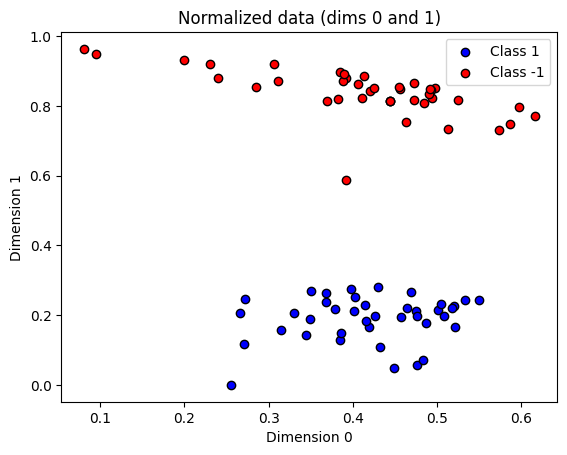

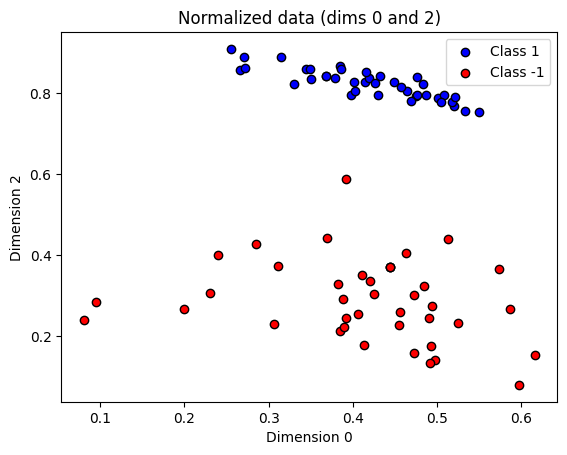

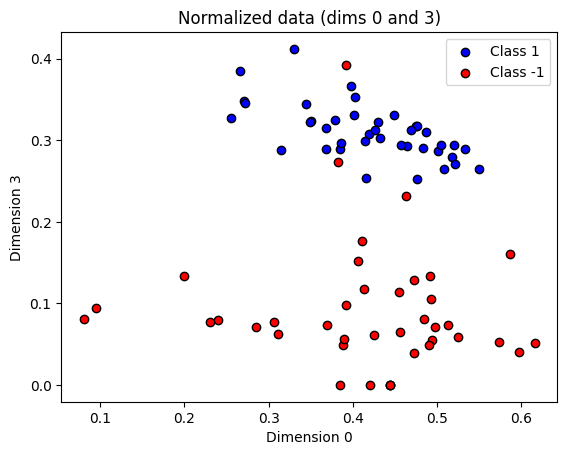

In [2]:
from modules.utils import plot_scatter

plot_scatter(X_train, Y_train, dim1=0, dim2=1, title="Normalized data (dims 0 and 1)")
plot_scatter(X_train, Y_train, dim1=0, dim2=2, title="Normalized data (dims 0 and 2)")
plot_scatter(X_train, Y_train, dim1=0, dim2=3, title="Normalized data (dims 0 and 3)")

<a id="2"></a>
## Ansatz

The Ansatz that we will use is described in the file "Variational_classifier". We have only changed state preparation method.

In the tutorial, they included the state preparation circuit according to the scheme in [Möttönen et al. (2004)](https://arxiv.org/abs/quant-ph/0407010). Additionally they  performed the decomposition of controlled Y-axis rotations.

However, we used the built-in function `qml.MottonenStatePreparation`. This built-in operation prepares an arbitrary state on the given wires using a decomposition into gates developed by [Möttönen et al. (2004)](https://arxiv.org/abs/quant-ph/0407010).
This state preparation stage prepares a specific quantum state using a series of RY rotation gates and CNOT gates. The RY gates apply rotations around the Y-axis, while the CNOT gates create entanglement between the qubits.

In [40]:
import pennylane as qml
import pennylane.numpy as np
state = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
state = state / np.linalg.norm(state)
dev2 = qml.device("default.qubit")

@qml.qnode(dev2)
def circuit(state):
    # State Preparation
    qml.MottonenStatePreparation(state_vector=state, wires=range(2))
    return qml.state()
print(circuit(state))
print(qml.draw(circuit, expansion_strategy="device", max_length=80)(state))

[0.53896774+0.j 0.79503606+0.j 0.27826503+0.j 0.        +0.j]
0: ──RY(0.56)─╭●───────────╭●─┤  State
1: ──RY(0.98)─╰X──RY(0.98)─╰X─┤  State


(<Figure size 2400x300 with 1 Axes>, <Axes: >)

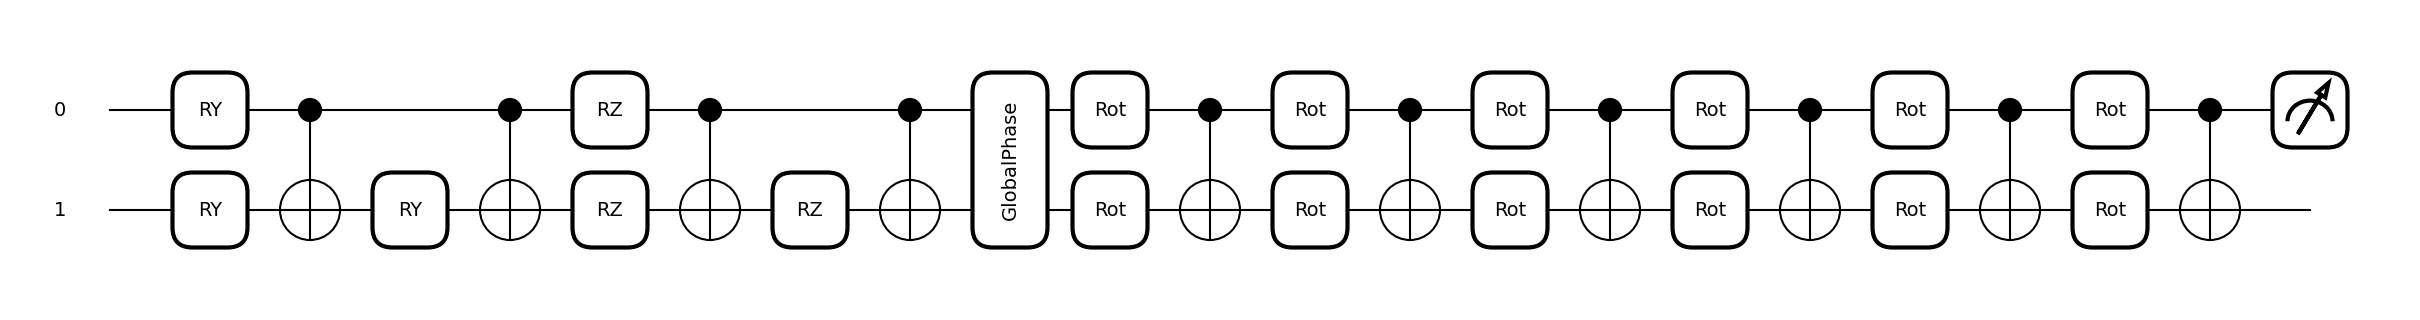

In [5]:
from modules.Ansatz import circuit
num_qubits = 2
num_layers = 6

state_prep='Mottonen'
weights= 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
circuit(weights, X_train[0], num_qubits, state_prep)
qml.draw_mpl(circuit, expansion_strategy="device")(weights, X_train[0], num_qubits, state_prep)

<a id="3"></a>
## Training
The next step is training the model with our data.

In [2]:
from modules.training import circuit_training
import pennylane.numpy as np
from modules.utils import load_and_prepare_iris_data
X_train, Y_train, X_val, Y_val, X_test, Y_test =load_and_prepare_iris_data(0.8,0.1,0.1)

num_qubits = 2
num_layers = 6

learning_rate = 0.01
batch_size = 5
num_epochs = 60
state_prep='Mottonen'

#Step 4: Use optimization techniques (like gradient descent) to update model parameter (classical part)
weights, costs, train_accuracies, val_accuracies, biases = circuit_training(X_train,Y_train,X_val, Y_val,num_qubits, num_layers,learning_rate,batch_size, num_epochs,state_prep=state_prep,seed = 0)

Y_train: Values: [-1.  1.] Counts: [40 40]
Y_val: Values: [-1.  1.] Counts: [4 6]
Y_test: Values: [-1.  1.] Counts: [6 4]
Epoch: 0 | Cost: 2.4295415 | Acc train: 0.0000000 | Acc validation: 0.0000000
Epoch: 1 | Cost: 2.8193139 | Acc train: 0.0000000 | Acc validation: 0.0000000
Epoch: 2 | Cost: 1.6502519 | Acc train: 0.2000000 | Acc validation: 0.0000000
Epoch: 3 | Cost: 1.7467082 | Acc train: 0.0000000 | Acc validation: 0.1000000
Epoch: 4 | Cost: 2.5472768 | Acc train: 0.4000000 | Acc validation: 0.5000000
Epoch: 5 | Cost: 3.1012637 | Acc train: 0.0000000 | Acc validation: 0.6000000
Epoch: 6 | Cost: 1.7979552 | Acc train: 0.4000000 | Acc validation: 0.6000000
Epoch: 7 | Cost: 0.3417578 | Acc train: 0.8000000 | Acc validation: 0.6000000
Epoch: 8 | Cost: 0.3234259 | Acc train: 1.0000000 | Acc validation: 0.9000000
Epoch: 9 | Cost: 0.2482286 | Acc train: 1.0000000 | Acc validation: 1.0000000
Epoch: 10 | Cost: 0.2096007 | Acc train: 1.0000000 | Acc validation: 1.0000000
Epoch: 11 | Cost: 0

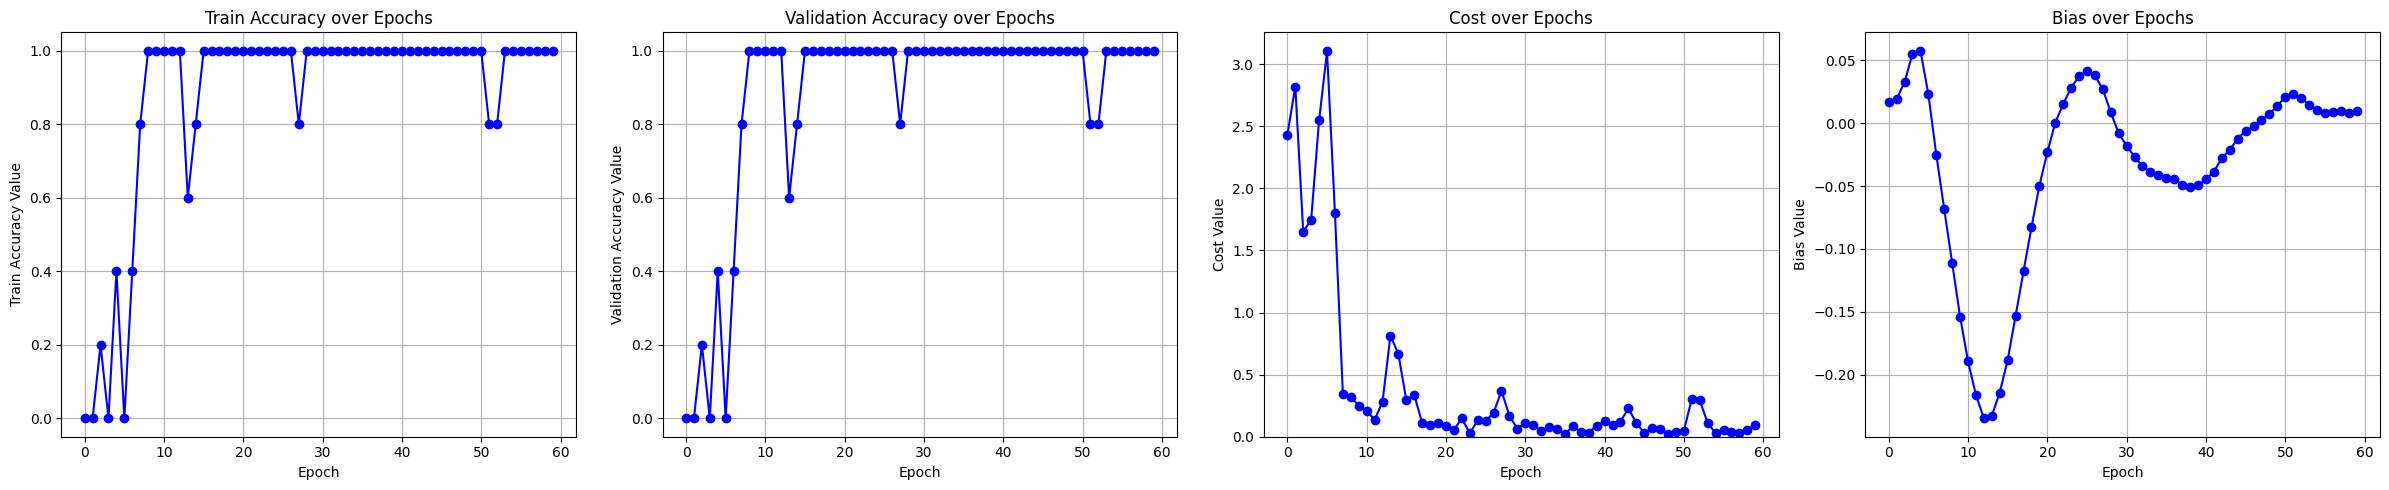

In [2]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': train_accuracies,
    'Cost': costs,
    'Bias': biases,
}
plot_metrics_over_epochs(metrics_dict)

The above plots displayed include:

* **Train Accuracy**: Shows how training accuracy evolves with epochs, indicating how well the model learns from training data.
* **Validation Accuracy**: Illustrates validation accuracy over epochs, revealing how well the model generalizes to unseen data.
* **Cost Function**: Displays the cost (or loss) function value over epochs, indicating how well the model fits the training data.
* **Bias**: Depicts changes in the bias parameter throughout training, showing adjustments made to improve model performance.

The training and validation accuracy both increase rapidly in the initial epochs, stabilizing at 100% around the 20th epoch, indicating effective learning and generalization. The cost value drops significantly within the first 10 epochs and remains low, reflecting successful minimization. The bias value fluctuates initially but converges to zero over time, suggesting stable model parameters.

<a id="4"></a>
## Metrics

Accuracy: 1.0 | Precision: 1.0 | Recall: 1.0 | F1 Score: 1.0 | AUC-ROC: 1.0


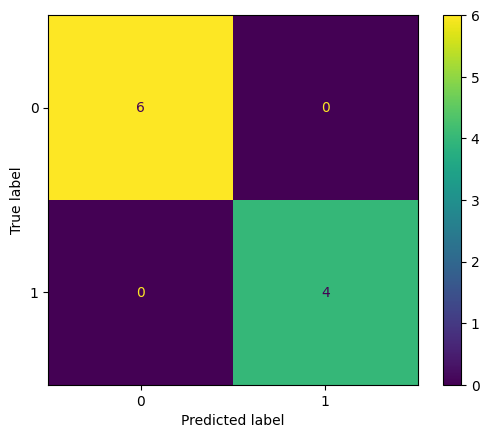

In [2]:
from modules.metrics import show_all_metrics
from modules.training import compute_predictions
from pennylane import numpy as np

bias_init = np.array(0.0, requires_grad=True)

test_predictions = compute_predictions(weights=weights, bias=bias_init, X = X_test, num_qubits=num_qubits, state_prep=state_prep)
show_all_metrics(Y_test,test_predictions)